In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Matplotlib created a temporary cache directory at /scratch/kphan/job_39078631/matplotlib-q7pfkk59 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "4g")\
    .config("spark.executor.instances", 18)\
    .getOrCreate()

In [3]:
dir = "/home/kphan/kphan/data/cleaned_data/cleaned_data_combined.csv"
df_cleaned = spark.read.csv(dir, header=True, inferSchema=True)

# Show df
df_cleaned.show(10)

+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|recommendationid|appid|          game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+-----------------+--------+-------

In [4]:
# df_cleaned.select("weighted_vote_score").summary().show()

In [5]:
# investigate_df = df_cleaned.filter(F.col("weighted_vote_score") > 1)
# investigate_df.show()

In [6]:
df_cleaned = df_cleaned.filter(F.col("weighted_vote_score") <= 1).cache()

In [7]:
# Bar graph which games have the most play time (of reviews)

# Looking to represent playtime statistics for each game

total_playtimes = (
    df_cleaned.groupBy("game")
    .agg(F.sum("author_playtime_at_review").alias("Total Reviewer Playtime (At time of review)"), F.count("*").alias("Review Count"))
    .withColumn("Average Playtime Per Review", F.round(F.col("Total Reviewer Playtime (At time of review)") / F.col("Review Count")))
)

total_playtimes.show()

+--------------------+-------------------------------------------+------------+---------------------------+
|                game|Total Reviewer Playtime (At time of review)|Review Count|Average Playtime Per Review|
+--------------------+-------------------------------------------+------------+---------------------------+
|        Smile For Me|                                     5200.0|         740|                        7.0|
|Startup Valley Ad...|                                       73.0|          24|                        3.0|
|GOD WARS The Comp...|                                     3422.0|         116|                       30.0|
|Warhammer 40,000:...|                                    37920.0|        1097|                       35.0|
|      Combate Monero|                                      104.0|          17|                        6.0|
|DOA6 Kula Diamond...|                                        0.0|           5|                        0.0|
|Just Cause™ 4: Se...|      

In [8]:
# Conversion of aggregated table to Pandas for visualization
top_10_reviewer_playtimes_df = total_playtimes.orderBy(F.col("Total Reviewer Playtime (At time of review)").desc()).limit(10).toPandas()
top_10_review_count_df = total_playtimes.orderBy(F.col("Review Count").desc()).limit(10).toPandas()

In [9]:
top_10_reviewer_playtimes_df

,game,Total Reviewer Playtime (At time of review),Review Count,Average Playtime Per Review
0,Counter-Strike 2,1.257245e+09,2471890,509.0
1,PUBG: BATTLEGROUNDS,1.715875e+08,598247,287.0
2,Team Fortress 2,1.648670e+08,311764,529.0
3,Rust,1.467509e+08,318794,460.0
4,Garry's Mod,1.120355e+08,278275,403.0
5,Tom Clancy's Rainbow Six Siege,1.108807e+08,370998,299.0
6,Warframe,9.852733e+07,162546,606.0
7,ARK: Survival Evolved,8.731481e+07,211471,413.0
8,Grand Theft Auto V,8.299498e+07,426958,194.0
9,Dead by Daylight,7.618871e+07,274167,278.0


In [10]:
top_10_review_count_df

,game,Total Reviewer Playtime (At time of review),Review Count,Average Playtime Per Review
0,Counter-Strike 2,1.257245e+09,2471890,509.0
1,PUBG: BATTLEGROUNDS,1.715875e+08,598247,287.0
2,Grand Theft Auto V,8.299498e+07,426958,194.0
3,Tom Clancy's Rainbow Six Siege,1.108807e+08,370998,299.0
4,Rust,1.467509e+08,318794,460.0
5,Terraria,5.555817e+07,313251,177.0
6,Team Fortress 2,1.648670e+08,311764,529.0
7,Garry's Mod,1.120355e+08,278275,403.0
8,Dead by Daylight,7.618871e+07,274167,278.0
9,PAYDAY 2,2.957681e+07,230464,128.0


/scratch/kphan/job_39078631/ipykernel_573017/2796111726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/scratch/kphan/job_39078631/ipykernel_573017/2796111726.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


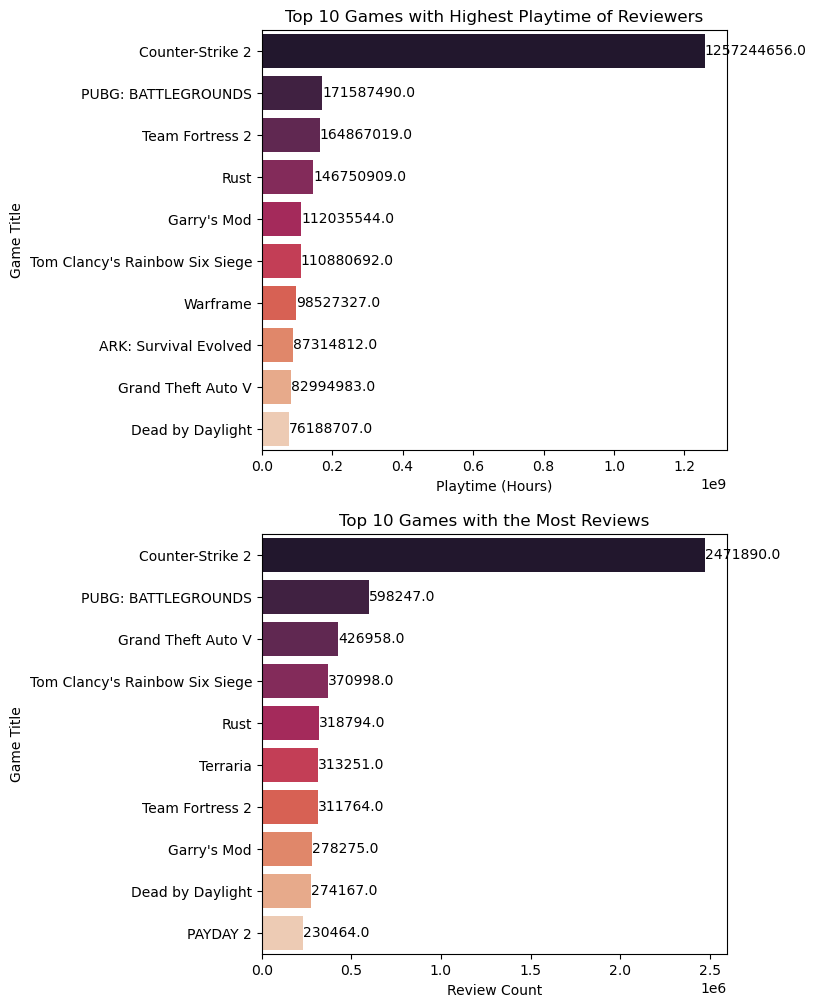

In [11]:
# Bargraph of top 10 games with the most total playtime per reviewer, top 10 games with most reviews
# Omitting stats on average playtime per review as would be skewed towards games with fewer reviews

fig, axes = plt.subplots(2,1,figsize = (6,12))

# Plot 1: Top 10 games with the most total playtime per reviewer
sns.barplot(
    y = top_10_reviewer_playtimes_df["game"],
    x = top_10_reviewer_playtimes_df["Total Reviewer Playtime (At time of review)"],
    ax = axes[0],
    palette = "rocket",
    orient = "h"
)
axes[0].set_title("Top 10 Games with Highest Playtime of Reviewers")
axes[0].set_ylabel("Game Title")
axes[0].set_xlabel("Playtime (Hours)")
for container in axes[0].containers:
  axes[0].bar_label(container, fmt='%.1f')

# Plot 2: Top 10 games with most reviews
sns.barplot(
    y = top_10_review_count_df["game"],
    x = top_10_review_count_df["Review Count"],
    ax = axes[1],
    palette = "rocket", 
    orient = "h"
)
axes[1].set_title("Top 10 Games with the Most Reviews")
axes[1].set_ylabel("Game Title")
axes[1].set_xlabel("Review Count")
for container in axes[1].containers:
  axes[1].bar_label(container, fmt='%.1f')

plt.show()

## Visualizations - Scatter Plots

In [12]:
# Curious to see if there is a pattern regarding playtime and weighted vote score

playtime_votescore_df = df_cleaned.select("weighted_vote_score", "author_playtime_at_review").toPandas()

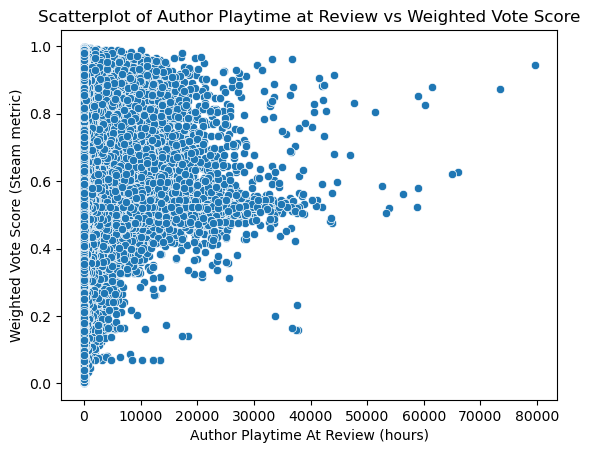

In [13]:
sns.scatterplot(
    data = playtime_votescore_df,
    y = "weighted_vote_score",
    x = "author_playtime_at_review"
)

plt.title("Scatterplot of Author Playtime at Review vs Weighted Vote Score")
plt.ylabel("Weighted Vote Score (Steam metric)")
plt.xlabel("Author Playtime At Review (hours)")

plt.show()

In [15]:
# spark.stop()